In [50]:
# From Python
# It requires OpenCV installed for Python
import sys
import cv2
import os
from sys import platform
import argparse
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [3]:
# Import Openpose (Windows/Ubuntu/OSX)
dir_path = os.path.dirname(os.path.realpath('__file__'))
try:
    # Change these variables to point to the correct folder (Release/x64 etc.)
    sys.path.append(dir_path + '/../bin/python/openpose/Release');
    os.environ['PATH']  = os.environ['PATH'] + ';' + dir_path + '/../x64/Release;' +  dir_path + '/../bin;'
    import pyopenpose as op
except ImportError as e:
    print('Error: OpenPose library could not be found. Did you enable `BUILD_PYTHON` in CMake and have this Python script in the right folder?')
    raise e

In [59]:
# Import Openpose (Windows/Ubuntu/OSX)
dir_path = os.path.dirname(os.path.realpath('__file__'))
try:
    # Change these variables to point to the correct folder (Release/x64 etc.)
    sys.path.append(dir_path + '/../bin/python/openpose/Release');
    os.environ['PATH']  = os.environ['PATH'] + ';' + dir_path + '/../x64/Release;' +  dir_path + '/../bin;'
    import pyopenpose as op
except ImportError as e:
    print('Error: OpenPose library could not be found. Did you enable `BUILD_PYTHON` in CMake and have this Python script in the right folder?')
    raise e
    
def extend_hand_box(box, image_height, image_width, extend):
    xmin, ymin, xmax, ymax = box 
    for i in range(extend):
        if xmin == 0 and xmax < image_width: 
            xmax += 1
            extend += 1
        elif xmin > 0 and xmax == image_width: 
            xmin -= 1
            extend += 1
        elif xmin <= 0 and xmax >= image_width:
            pass
        else: 
            xmin, xmax = xmin - 1, xmax + 1

        if ymin == 0 and ymax < image_height: 
            ymax += 1
            extend += 1
        elif ymin > 0 and ymax == image_height:
            ymin -= 1
            extend += 1
        elif ymin <= 0 and ymax >= image_height:
            pass
        else: 
            ymin, ymax = ymin - 1, ymax + 1
    
    xmin = 0 if xmin<0 else xmin
    ymin = 0 if ymin<0 else ymin
    xmax = image_width if xmax > image_width else xmax
    ymax = image_height if ymax > image_height else ymax
    
    return xmin, ymin, xmax, ymax

def find_bounded_sqaure(box):
    xmin, ymin, xmax, ymax = box 
    x = (xmax-xmin)/2 + xmin
    y = (ymax-ymin)/2 + ymin
    extend = max(xmax-xmin, ymax-ymin)/2 
    new_xmin, new_ymin = x-extend, y-extend
    new_xmax, new_ymax = x+extend, y+extend
    return new_xmin, new_ymin, new_xmax, new_ymax

def convert_to_op_rectangle(box, image_height, image_width, extend=50):
    bounded_sqaure = find_bounded_sqaure(box)
#     print(bounded_sqaure)
    xmin, ymin, xmax, ymax = extend_hand_box(bounded_sqaure, image_height, image_width, extend)
    width = abs(xmax - xmin)
    height = abs(ymax - ymin)
    length = max(width, height)
    hand_rectangle = op.Rectangle(xmin, ymin, length, length)
    return hand_rectangle

In [37]:
# Custom Params (refer to include/openpose/flags.hpp for more parameters)
params = dict()
params["model_folder"] = "../models/"
params["hand"] = True
params["hand_detector"] = 2
params["body"] = 0

# Starting OpenPose
opWrapper = op.WrapperPython()
opWrapper.configure(params)
opWrapper.start()

In [84]:
# Read image and face rectangle locations
image_path = r'D:\PuMuxin\FreiHand\orginal\naked_hands\00000527.jpg'#00000057.jpg'
imageToProcess = cv2.imread(image_path)

# From body pose 
hand_boxes = [[65.52327728271484, 55.68765640258789, 158.0999755859375, 176.36659240722656]]

# Convert to openpose hands rectangles
height, width = imageToProcess.shape[:2]
handRectangles = [[convert_to_op_rectangle(box, height, width, 30), convert_to_op_rectangle(box, height, width, 30)] for box in hand_boxes]

# Create new datum
datum = op.Datum()
datum.cvInputData = imageToProcess
datum.handRectangles = handRectangles

# Process and display image
opWrapper.emplaceAndPop(op.VectorDatum([datum]))
print("Left hand keypoints: \n" + str(datum.handKeypoints[0]))
print("Right hand keypoints: \n" + str(datum.handKeypoints[1]))

keypoints = datum.handKeypoints

Left hand keypoints: 
[[[ 96.591385   152.85028      0.23345417]
  [110.3387     141.55785      0.3137185 ]
  [124.086006   120.93688      0.67883813]
  [137.83331    103.261765     0.7940896 ]
  [149.12575     89.02348      0.8780148 ]
  [ 83.82603    109.64445      0.2090877 ]
  [ 85.789925   102.279816     0.35218492]
  [ 97.57333     99.824936     0.42716107]
  [105.91992    100.31592      0.36251006]
  [ 87.75383     98.35201      0.24961372]
  [ 82.84408     84.11372      0.6333772 ]
  [101.50114     86.5686       0.7359456 ]
  [115.24845     93.933235     0.67346597]
  [ 94.62749     90.49641      0.17240869]
  [ 91.19066     74.785194     0.604424  ]
  [108.86577     78.22202      0.6772673 ]
  [121.14015     86.07763      0.73845756]
  [ 98.55529     78.22202      0.18828806]
  [103.46504     68.89349      0.7824003 ]
  [114.75748     69.87544      0.7776095 ]
  [126.540886    75.27617      0.7900597 ]]]
Right hand keypoints: 
[[[102.48309    155.79613      0.42588556]
  [117.

In [85]:
def get_predicted_keypoints_coordinates(keypoints):
    no = 0
    coordinates = []
    for hand_list in keypoints:
        for hand in hand_list:
            this_hand = []
            no += 1
            print("hand no: " + str(no))
            for i in range(21):
                this_hand.append(list(hand[i,:2]))
                print(str(i) + ': ' + str(list(hand[i,:2])))
            coordinates.append(this_hand)
    return coordinates

coordinates = get_predicted_keypoints_coordinates(keypoints)

hand no: 1
0: [96.591385, 152.85028]
1: [110.3387, 141.55785]
2: [124.086006, 120.93688]
3: [137.83331, 103.261765]
4: [149.12575, 89.02348]
5: [83.82603, 109.64445]
6: [85.789925, 102.279816]
7: [97.57333, 99.824936]
8: [105.91992, 100.31592]
9: [87.75383, 98.35201]
10: [82.84408, 84.11372]
11: [101.50114, 86.5686]
12: [115.24845, 93.933235]
13: [94.62749, 90.49641]
14: [91.19066, 74.785194]
15: [108.86577, 78.22202]
16: [121.14015, 86.07763]
17: [98.55529, 78.22202]
18: [103.46504, 68.89349]
19: [114.75748, 69.87544]
20: [126.540886, 75.27617]
hand no: 2
0: [102.48309, 155.79613]
1: [117.21236, 140.5759]
2: [126.04991, 120.44591]
3: [140.28821, 102.279816]
4: [150.10771, 88.04153]
5: [103.46505, 103.261765]
6: [103.46505, 69.87544]
7: [116.23041, 70.36642]
8: [128.01381, 75.27617]
9: [90.699684, 106.69859]
10: [92.172615, 74.785194]
11: [108.865776, 78.713]
12: [121.14016, 86.5686]
13: [85.78993, 114.063225]
14: [83.33505, 85.09568]
15: [101.501144, 87.05958]
16: [114.2665, 94.42421]

In [86]:
coordinates[0]

[[96.591385, 152.85028],
 [110.3387, 141.55785],
 [124.086006, 120.93688],
 [137.83331, 103.261765],
 [149.12575, 89.02348],
 [83.82603, 109.64445],
 [85.789925, 102.279816],
 [97.57333, 99.824936],
 [105.91992, 100.31592],
 [87.75383, 98.35201],
 [82.84408, 84.11372],
 [101.50114, 86.5686],
 [115.24845, 93.933235],
 [94.62749, 90.49641],
 [91.19066, 74.785194],
 [108.86577, 78.22202],
 [121.14015, 86.07763],
 [98.55529, 78.22202],
 [103.46504, 68.89349],
 [114.75748, 69.87544],
 [126.540886, 75.27617]]

In [87]:
coordinates[1]

[[102.48309, 155.79613],
 [117.21236, 140.5759],
 [126.04991, 120.44591],
 [140.28821, 102.279816],
 [150.10771, 88.04153],
 [103.46505, 103.261765],
 [103.46505, 69.87544],
 [116.23041, 70.36642],
 [128.01381, 75.27617],
 [90.699684, 106.69859],
 [92.172615, 74.785194],
 [108.865776, 78.713],
 [121.14016, 86.5686],
 [85.78993, 114.063225],
 [83.33505, 85.09568],
 [101.501144, 87.05958],
 [114.2665, 94.42421],
 [82.3531, 122.90078],
 [85.78993, 101.78884],
 [99.53725, 100.31592],
 [110.3387, 101.78884]]

In [88]:
def annotate_image(points, oriImg):
    edges = [[0, 1], [1, 2], [2, 3], [3, 4], [0, 5], [5, 6], [6, 7], [7, 8], [0, 9], [9, 10], \
             [10, 11], [11, 12], [0, 13], [13, 14], [14, 15], [15, 16], [0, 17], [17, 18], [18, 19], [19, 20]]

    plt.imshow(oriImg[:, :, [2, 1, 0]])

    for i, (x, y) in enumerate(points):
        plt.plot(x, y, 'r.')
        plt.text(x, y, str(i))

    for ie, e in enumerate(edges):
        rgb = matplotlib.colors.hsv_to_rgb([ie / float(len(edges)), 1.0, 1.0])
        x1, y1 = points[e[0]]
        x2, y2 = points[e[1]]
        plt.plot([x1, x2], [y1, y2], color=rgb)
    plt.axis('off')
    plt.show()

# Prediction

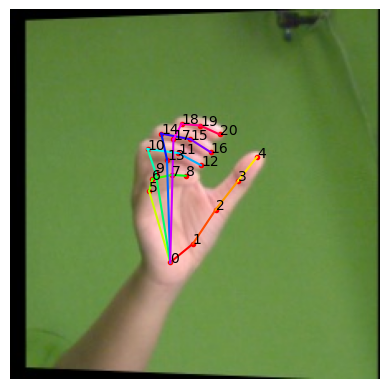

In [91]:
annotate_image(coordinates[0], imageToProcess)

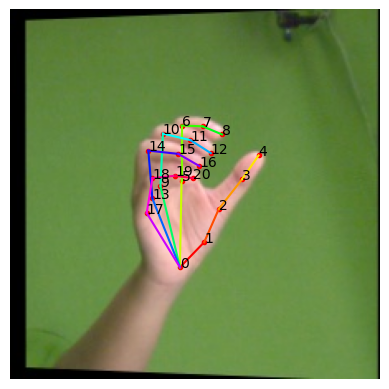

In [90]:
# Provide the same hand rectangle for both right and left, then caculate using the highest average key error
annotate_image(coordinates[1], imageToProcess)

# Bechmark 

In [96]:
import json

def projectPoints(xyz, K):
    """ Project 3D coordinates provided by the hands dataset into image space. """
    xyz = np.array(xyz)
    K = np.array(K)
    uv = np.matmul(K, xyz.T).T
    return uv[:, :2] / uv[:, -1:]

def read_json_data(file_path):
    with open(file_path) as file:
        content = json.load(file)
    return content

In [97]:
dataset_dir=r'D:\PuMuxin\FreiHand'
xyz_array = read_json_data(f'{dataset_dir}\\training_xyz.json')
k_array = read_json_data(f'{dataset_dir}\\training_k.json')

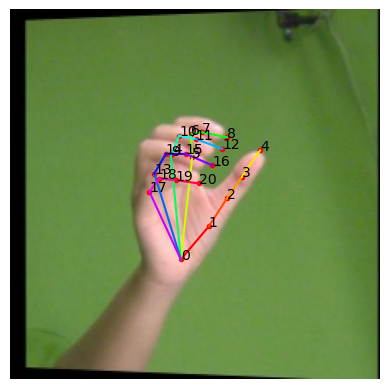

In [100]:
index = 527
actual_coordinate = projectPoints(xyz_array[index], k_array[index]).astype(np.int32)
annotate_image(actual_coordinate, imageToProcess)

# Check if the selected images from HandDB contains only left hands

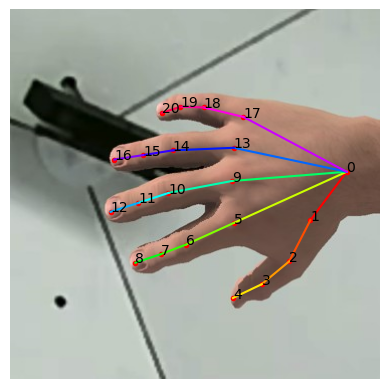

In [104]:
image_path = r'D:\PuMuxin\HandDB\original\synth2\00000362.jpg'
image = cv2.imread(image_path)
actual_coordinate = [[334.6609191894531, 161.1590576171875], [298.5533447265625, 209.447509765625], [277.4411926269531, 250.39584350585938], [250.01370239257812, 273.187255859375], [221.52548217773438, 286.81390380859375], [222.368896484375, 212.08949279785156], [174.46893310546875, 233.7650604248047], [149.45326232910156, 243.2719268798828], [124.39868927001953, 251.6853485107422], [220.21900939941406, 170.39413452148438], [157.24581909179688, 182.2622833251953], [127.33379364013672, 192.12232971191406], [99.61463165283203, 201.0711212158203], [222.33091735839844, 137.29974365234375], [161.43927001953125, 139.87738037109375], [131.91390991210938, 144.6006317138672], [103.46319580078125, 148.97821044921875], [231.9629364013672, 106.5650405883789], [192.22235107421875, 97.09149932861328], [169.2294921875, 96.48527526855469], [150.70314025878906, 102.51095581054688]]
annotate_image(actual_coordinate, image)